<a href="https://colab.research.google.com/github/timonpalm/TFCourse/blob/main/07_food_vision_milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

# Check GPU

Not all GPU's are compatible with Mixture Learning. GPU needs to have a combuting factor equal or higher than 7.0.
So choose Tesla T4 GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4e0ac43c-69ac-5255-5dd5-0a97ad130886)


In [3]:
# Download helper function
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-23 12:59:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-23 12:59:14 (82.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


# Use Tensorflow Dataset to download data

In [5]:
# Get Tensorflow Datasets
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'bot_adversarial_dialogue',
 'bridge',
 'bucc',
 'c4',
 'c4_wsrs',
 'caltech101',
 'caltech_birds2010',
 'caltech_b

In [7]:
# Load in the data (takes 506 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train[:50%]", "validation"], # just use 50 % of the dataset
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteG7BZVC/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteG7BZVC/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the data

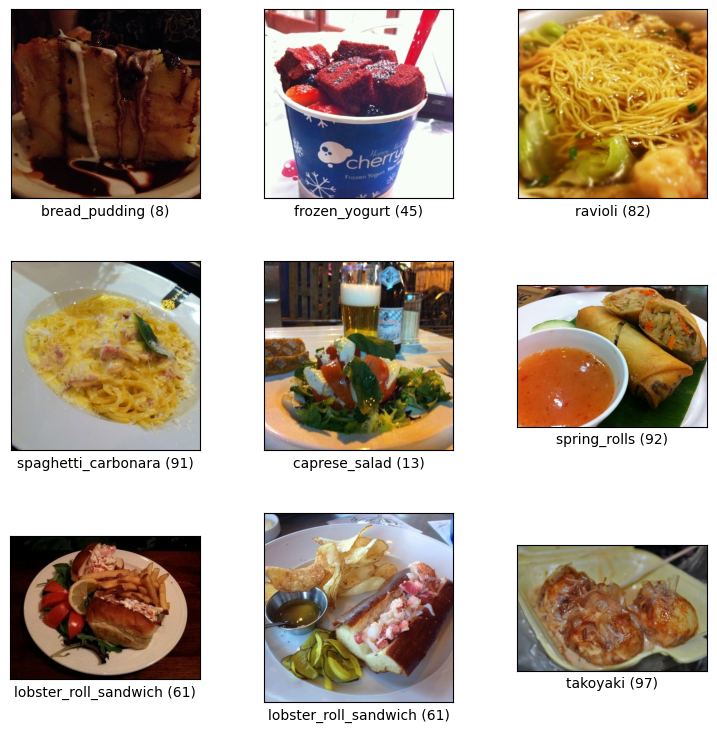

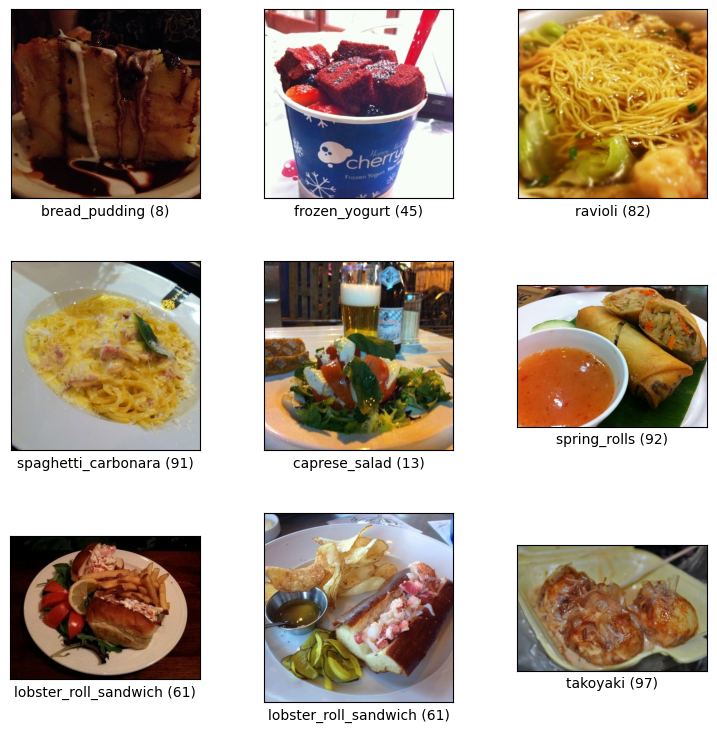

In [22]:
tfds.show_examples(train_data, ds_info)

In [23]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir=PosixGPath('/tmp/tmpgmtgxv1ntfds'),
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examp

In [24]:
train_per_class = int(ds_info.splits["train"].num_examples / ds_info.features["label"].num_classes)
print(f"There are {train_per_class} examples per class")

There are 750 examples per class


In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [25]:
len(train_data)

37875

In [ ]:
train_one_sample = train_data.take(1)

In [ ]:
train_one_sample # show one sample

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image sahpe: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name: {class_names[label.numpy()]}
  """)

In [ ]:
image

In [ ]:
tf.reduce_min(image), tf.reduce_max(image)

## Plot an image from TensorFlow Dataset

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return (tf.cast(image, tf.float32), label)

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img

## Batch and prepare datasets

We're now going to make our data input pipeline really fast.

In [ ]:
# map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

# Setup mixed precision training

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# build feature extraction model

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

augmentation_layer = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="augmentation")

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNet has rescaling built-in

x = augmentation_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="predictions")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
model.summary()

# Checking layer dtype policies

In [ ]:
# Check the dtype_policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check the dtype in EfficientNet:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

# Fit the Feature Extraction Model

In [ ]:
# install, login and import weights and biases
! pip install wandb
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

## TRAINING CONFIG

In [ ]:
from types import SimpleNamespace

CONFIG = SimpleNamespace(
    base_model = "EfficientNetB0",
    batch_size = 32,
    percent_of_data = 0.5,
    percent_of_val = 0.1,
    epochs = 8,
    optimizer = "Adam",
    num_fine_tune_layers = 20
)

In [ ]:
wandb.init(
    #name="First Run", # SET THE RUN NAME
    project="Food_101_Milestone", # SET THE PROJECT NAME
    tags=["EfficientNetB0"], # LIST OF TAGS
    config=CONFIG
    )

In [ ]:
# model checkpoint callback
model_ckpt = WandbModelCheckpoint(
    filepath="model_checkpoints/model-{epoch:02d}-{val_accuracy:.2f}.h5",
    monitor="val_accuracy",
    #save_best_only=True,
    save_weights_only=True,
    mode="max"
)

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=CONFIG.epochs,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                      validation_steps=int(CONFIG.percent_of_val * len(test_data)),
                                                      callbacks=[model_ckpt, WandbMetricsLogger()],
                                                     workers=2)

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [ ]:
# evaluade with 100% of test date
val_loss, val_score = model.evaluate(test_data)
wandb.log({"val_accuracy_all_data": val_score,
           "val_loss_all_data": val_loss})

# Finetune the model

## Adapt the model

In [54]:
for layer in model.layers[-20:]:
  layer.tranible = True

In [55]:
# decrese learning rate by 10
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
history_101_food_classes_fine_tune = model.fit(train_data,
                                                     epochs=2*CONFIG.epochs,
                                                      steps_per_epoch=len(train_data),
                                                      validation_data=test_data,
                                                      validation_steps=int(CONFIG.percent_of_val * len(test_data)),
                                                      callbacks=[model_ckpt, WandbMetricsLogger(
                                                          initial_global_step=CONFIG.epochs*len(train_data))],
                                               initial_epoch=CONFIG.epochs,
                                               workers=2)


Epoch 6/10
947/947 [==============================] - 114s 109ms/step - loss: 1.2518 - accuracy: 0.6751 - val_loss: 1.2084 - val_accuracy: 0.6721
Epoch 7/10
947/947 [==============================] - 101s 104ms/step - loss: 1.2314 - accuracy: 0.6821 - val_loss: 1.2022 - val_accuracy: 0.6727
Epoch 8/10
947/947 [==============================] - 89s 91ms/step - loss: 1.2217 - accuracy: 0.6827 - val_loss: 1.2012 - val_accuracy: 0.6742
Epoch 9/10
947/947 [==============================] - 96s 99ms/step - loss: 1.2097 - accuracy: 0.6861 - val_loss: 1.1966 - val_accuracy: 0.6743
Epoch 10/10
674/947 [====================>.........] - ETA: 21s - loss: 1.2231 - accuracy: 0.6818

In [ ]:
plot_loss_curves(history_101_food_classes_fine_tune)

In [ ]:
# evaluade with 100% of test date
val_loss, val_score = model.evaluate(test_data)
wandb.log({"val_accuracy_all_data": val_score,
           "val_loss_all_data": val_loss})

In [ ]:
wandb.finish()

# Load the best model from weights and biases

In [3]:
run = wandb.init()
artifact = run.use_artifact('timonpalm/Food_101_Milestone/run_5y1523c8_model:v8', type='model')
artifact_dir = artifact.download()

wandb: Currently logged in as: timonpalm. Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


In [42]:
model.load_weights("/content/artifacts/run_5y1523c8_model:v8/model-09-0.67.h5")

In [43]:
model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.2078 - accuracy: 0.6725


[1.2077940702438354, 0.6724752187728882]